In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from matplotlib import pyplot
import scipy as sp
import sklearn
import seaborn as sb
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor

In [2]:
filename = 'events.csv'
events = pd.read_csv('football-events/events.csv')
ginf = pd.read_csv('football-events/ginf.csv')


In [3]:
# Number of shots
attempts = events[(events.event_type==1)]
shotsSorted = attempts.groupby(['id_odsp', 'side']).count().reset_index()
shotsClean = shotsSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"shot_count"})

# Number of corners
corners = events[(events.event_type==2)]
cornersSorted = corners.groupby(['id_odsp', 'side']).count().reset_index()
cornersClean = cornersSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"corner_count"})

# Number of fouls
fouls = events[(events.event_type==3)]
foulsSorted = fouls.groupby(['id_odsp', 'side']).count().reset_index()
foulsClean = foulsSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"foul_count"})

# Number of yellow cards
yellow_cards = events[(events.event_type==4)]
ycSorted = yellow_cards.groupby(['id_odsp', 'side']).count().reset_index()
ycClean = ycSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"yellow_card_count"})

# Number of second yellow cards
second_yellow_cards= events[(events.event_type==5)]
sycSorted = second_yellow_cards.groupby(['id_odsp', 'side']).count().reset_index()
sycClean = sycSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"second_yellow_card_count"})

# Number of red cards
red_cards = events[(events.event_type==6)]
redCardsSorted = red_cards.groupby(['id_odsp', 'side']).count().reset_index()
redCardsClean = redCardsSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"red_card_count"})

# Number of freekicks
free_kicks = events[(events.event_type==8)]
fkSorted = free_kicks.groupby(['id_odsp', 'side']).count().reset_index()
fkClean = fkSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"free_kick_count"})

# Number of offsides
offsides = events[(events.event_type==9)].copy()
offsidesSorted = offsides.groupby(['id_odsp', 'side']).count().reset_index()
offsidesClean = offsidesSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"offside_count"})

# Number of Penalties won
penalties = events[(events.event_type==11)].copy()
penalties['side'] = penalties['side'].map({1:2,2:1})
pksorted = penalties.groupby(['id_odsp', 'side']).count().reset_index()
pkclean = pksorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"Pk_won_count"})




In [4]:
pkclean

,id_odsp,side,Pk_won_count
0,00WAhrVe/,1,1
1,00Wld37M/,2,1
2,02tzvPZD/,1,1
3,04GXLvyK/,2,1
4,04Oyn4RO/,2,1
...,...,...,...
2448,zwL8Nn5O/,2,1
2449,zwezqiJa/,1,1
2450,zwoMNmRl/,1,1
2451,zwqUsmIH/,1,2


In [5]:
joinColumns = ['id_odsp', 'side']
fullDataset = shotsClean
fullDataset = fullDataset.merge(cornersClean, on=joinColumns, how='left') 
#fullDataset = fullDataset.merge(ycClean, on=joinColumns, how='left') 
#fullDataset = fullDataset.merge(sycClean, on=joinColumns, how='left') 
#fullDataset = fullDataset.merge(redCardsClean, on=joinColumns, how='left') 
fullDataset = fullDataset.merge(fkClean, on=joinColumns, how='left') 
#fullDataset = fullDataset.merge(offsidesClean, on=joinColumns, how='left')
fullDataset = fullDataset.merge(pkclean, on=joinColumns, how='left') 
fullDataset = fullDataset.fillna(0)

In [6]:
fullDataset['side'] = fullDataset['side'].map({1: 0,2 : 1})
fullDataset.astype({'side': 'bool'}).dtypes

id_odsp             object
side                  bool
shot_count           int64
corner_count       float64
free_kick_count    float64
Pk_won_count       float64
dtype: object

In [7]:
X = fullDataset.drop(['id_odsp','shot_count'],axis = 1)
y = fullDataset['shot_count']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)
mlp = MLPRegressor(random_state=0, hidden_layer_sizes=(28, 28, 28, 28), max_iter=20000, activation='relu')
mlp.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(28, 28, 28, 28), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=20000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=0, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [9]:
res = mlp.score(X_test, y_test)
print(f'On test we get {res}')

On test we get 0.29382438474546724


In [10]:
randForest = RandomForestRegressor(n_estimators=5000, max_features=None)
randForest.fit(X_train, y_train)
print(f'On test we get {randForest.score(X_test, y_test)}')

On test we get 0.22550378121790637


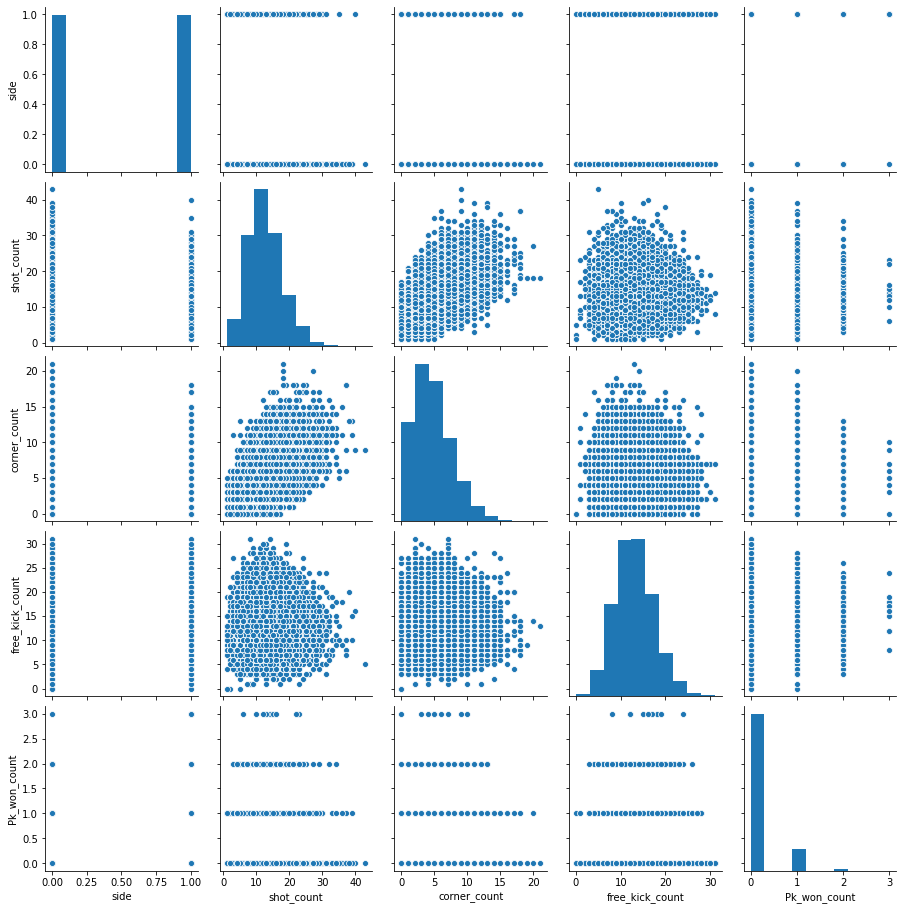

In [11]:
sb.pairplot(fullDataset)